In [1]:
import numpy as np
import random
import os
import pickle
import cv2

<h2>Dataset<h2>

In [2]:
def MNIST(path, type):
    labels_cnt = [0 for _ in range(10)] #设置计数列表
    image_limit = []
    labels_limit = []
    if type == 'train':
        image_list, label_list = [], []
        limit = 500 #设置上界
        filename = os.path.join(path, 'train-images-idx3-ubyte')
        with open(filename, 'rb') as file:
            data = np.frombuffer(file.read(), np.uint8, offset=16).reshape(-1, 1, 28, 28) / 255.0 #转化格式
        filename = os.path.join(path, 'train-labels-idx1-ubyte')
        with open(filename, 'rb') as file:
            label = np.frombuffer(file.read(), np.uint8, offset=8)
        for img,labels in zip(data, label):
            if labels_cnt[labels] < limit:
                image_limit.append(img)
                labels_limit.append(labels)
                labels_cnt[labels] += 1

    else:
        limit = 100
        filename = os.path.join(path, 't10k-images-idx3-ubyte')
        with open(filename, 'rb') as file:
            data = np.frombuffer(file.read(), np.uint8, offset=16).reshape(-1, 1, 28, 28) / 255.0
        filename = os.path.join(path, 't10k-labels-idx1-ubyte')
        with open(filename, 'rb') as file:
            label = np.frombuffer(file.read(), np.uint8, offset=8)
        for img,labels in zip(data, label):
            if labels_cnt[labels] < limit:
                image_limit.append(img)
                labels_limit.append(labels)
                labels_cnt[labels] += 1

    image_limit = np.array(image_limit)
    labels_limit = np.array(labels_limit)
    index = np.random.permutation(len(labels_limit))
    return image_limit[index], labels_limit[index]

def CIFAR10(path, type):
    labels_cnt = [0 for _ in range(10)]
    image_limit = []
    labels_limit = []
    if type == 'train':
        image_list, label_list = [], []
        limit = 500
        for i in range(1, 6): #遍历数据集的所有ttain data
            filename = os.path.join(path, 'data_batch_{}'.format(i))
            with open(filename, 'rb') as file:
                data = pickle.load(file, encoding='bytes')
            image_list.append(np.array(data[b'data'], dtype=np.float32).reshape(-1, 3, 32, 32) / 255.0)
            label_list.append(np.array(data[b'labels'], dtype=np.int32))

        for img_ba,labels_ba in zip(image_list, label_list):
            for img, labels in zip(img_ba,labels_ba):
                if labels_cnt[labels] < limit:
                    image_limit.append(img)
                    labels_limit.append(labels)
                    labels_cnt[labels] += 1

    else:
        limit = 100
        filename = os.path.join(path, 'test_batch')
        with open(filename, 'rb') as file:
            data = pickle.load(file, encoding='bytes')
        image = np.array(data[b'data'], dtype=np.float32).reshape(-1, 3, 32, 32) / 255.0
        label = np.array(data[b'labels'], dtype=np.int32)
        for img,labels in zip(image, label):
            if labels_cnt[labels] < limit:
                image_limit.append(img)
                labels_limit.append(labels)
                labels_cnt[labels] += 1

    image_limit = np.array(image_limit)
    labels_limit = np.array(labels_limit)
    index = np.random.permutation(len(labels_limit))
    return image_limit[index], labels_limit[index]

<h2>Kernel<h2>

In [3]:
class CreateKernel(object):
    def __init__(self, kernel):
        self.name = kernel['name']
        self.param = kernel.get('param', {})
    
    def __call__(self, X, Z):
        if self.name == 'linear':
            return self.linear_kernel(X, Z)
        elif self.name == 'polynomial':
            return self.polynomial_kernel(X, Z, **self.param)
        elif self.name == 'gaussian':
            return self.gaussian_kernel(X, Z, **self.param)
        elif self.name == 'sigmoid':
            return self.sigmoid_kernel(X, Z, **self.param)
    # 计算各种核的K
    def linear_kernel(self, X, Z):
        return np.dot(X, Z.T)

    def polynomial_kernel(self, X, Z, degree=4, gamma=0.07, zeta=1):
        return np.power(np.dot(X, Z.T) * gamma + zeta, degree)

    def gaussian_kernel(self, X, Z, gamma=0.03):
        return np.exp(-gamma * np.sum(np.square(X-Z), axis=1))

    def sigmoid_kernel(self, X, Z, gamma=0.01, coef0=-1):
        return np.tanh(gamma * np.dot(X, Z.T) + coef0)

<h2>SVM with Single Kernel<h2>

In [4]:
class SVM_2(object):
    def __init__(self, kernel=None, epsilon=1e-3, C=1, max_iter=100):
        self.C = C
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.kernel = CreateKernel(kernel=kernel)
    #随机取i以外的j
    def randomchoose(self, i, maxnum):
        while True:
            j = random.randint(0, maxnum-1)
            if j != i:
                return j
    #计算得到的wx+b
    def calc_val(self, i):
        return np.dot((self.alpha * self.y), self.K[:,i]) + self.b
    #计算w
    def calc_w(self):
        return np.dot((self.y * self.alpha), self.X)
    #计算b
    def cal_b(self):
        return self.b
    #训练
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.alpha = np.zeros(X.shape[0])
        self.b = 0
        self.K = np.zeros((X.shape[0], X.shape[0]))
        it = 0
        for i in range(X.shape[0]):
            self.K[:, i] = self.kernel(X, X[i, :])
        while it < self.max_iter: # 设置最大循环数以内进行训练
            '''SMO算法(报告中所推导的)'''
            pairchange = 0
            for i in range(X.shape[0]):
                j = self.randomchoose(i, X.shape[0])
                alpha_i, x_i, y_i = self.alpha[i], self.X[i], self.y[i]
                cal_y_i = self.calc_val(i)
                E_i = cal_y_i - y_i
                alpha_j, x_j, y_j = self.alpha[j], self.X[j], self.y[j]
                cal_y_j = self.calc_val(j)
                E_j = cal_y_j - y_j
                if (self.K[i, i] + self.K[j, j] - 2 * self.K[i, j] <= 0):
                    continue
                alpha_j_new = alpha_j + (y_j * (E_i - E_j)) / (self.K[i, i] + self.K[j, j] - 2 * self.K[i, j])
                #设置范围HL并更新alpha
                if y_i == y_j:
                    L = max(0, alpha_i + alpha_j - self.C)
                    H = min(self.C, alpha_i + alpha_j)
                else:
                    L = max(0, alpha_j - alpha_i)
                    H = max(self.C, self.C + alpha_j - alpha_i)
                if L == H:
                    continue
                if alpha_j_new < L:
                    alpha_j_new = L
                elif alpha_j_new > H:
                    alpha_j_new = H
                else:
                    alpha_j_new = alpha_j_new
                if abs(alpha_j_new - alpha_j) < self.epsilon:
                    continue
                else:
                    self.alpha[i] = alpha_i + y_i * y_j * (alpha_j - alpha_j_new)
                    self.alpha[j] = alpha_j_new
                #更新b
                if (0 < self.alpha[i]) & (self.alpha[i] < self.C):
                    self.b = -E_i + (alpha_i - self.alpha[i]) * y_i * self.K[i, i] + (alpha_j - self.alpha[j]) * y_j * self.K[j, i] + self.b
                elif (0 < self.alpha[j]) & (self.alpha[j] < self.C):
                    self.b = -E_j - y_i * self.K[i, j] * (self.alpha[i] - alpha_i) - y_j * self.K[j, j] * (self.alpha[j] - alpha_j) + self.b
                else:
                    self.b = ((-E_i + (alpha_i - self.alpha[i]) * y_i * self.K[i, i] + (alpha_j - self.alpha[j]) * y_j * self.K[j, i] + self.b) + (-E_j - y_i * self.K[i, j] * (self.alpha[i] - alpha_i) - y_j * self.K[j, j] * (self.alpha[j] - alpha_j) + self.b)) / 2
                pairchange += 1
            it += 1

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            y_pred[i] = np.dot((self.y * self.alpha), self.kernel(self.X, X[i, :])) + self.b
            if y_pred[i] >= 0:
                y_pred[i] = 1
            else:
                y_pred[i] = -1
        return y_pred                

class SVM_mul(object):
    def __init__(self, kernel=None, epsilon=1e-3, C=1, max_iter=100):
        self.C = C
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.kernel = kernel
        self.modelselect = []

    def fit(self, X, y):
        label = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        #训练所有的SVM二分类器
        for i in label:
            for j in range(i+1, 10):
                model = SVM_2(self.kernel, self.epsilon, self.C, self.max_iter)
                self.modelselect.append((model, i, j))
        for model, i, j in self.modelselect:
            X_ij = []
            y_ij = []
            for check in range(y.shape[0]):
                if (y[check] == i) | (y[check] == j):
                    X_ij.append(X[check])
                    y_ij.append(y[check])
            for check in range(len(y_ij)):
                if y_ij[check] == i:
                    y_ij[check] = 1
                else:
                    y_ij[check] = -1
            X_ij = np.array(X_ij)
            y_ij = np.array(y_ij)
            model.fit(X_ij, y_ij)

    def predict(self, X):
        res = np.zeros((X.shape[0], 10))
        for model, i, j in self.modelselect:
            y_pred = model.predict(X)
            for check in range(y_pred.shape[0]):
                if y_pred[check] == 1:
                    res[check, i] += 1
                else:
                    res[check, j] += 1
        label = []
        for k in range(y_pred.shape[0]):
            #选取解得次数最高的一个标签
            output = np.argmax(res[k])
            label.append(output)
        label = np.array(label)
        return label

<h2>SVM with Multiple Kernels<h2>

In [6]:
class MKL_2(object):
    def __init__(self, kernel=None, epsilon=1e-3, C=1, max_iter=100, decay = 0.3):
        self.C = C
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.kernel_set = []
        self.decay = decay
        for k in kernel:
            self.kernel_set.append(CreateKernel(kernel=k))

    def randomchoose(self, i, maxnum):
        while True:
            j = random.randint(0, maxnum-1)
            if j != i:
                return j
    
    def calc_val(self, i):
        return np.dot((self.alpha * self.y), self.K[:,i]) + self.b

    def calc_w(self):
        return np.dot((self.y * self.alpha), self.X)
    
    def cal_b(self):
        return self.b

    def kernel(self, X, y):
        return np.sum([self.lamda[i] * self.kernel_set[i](X, y) for i in range(len(self.kernel_set))], axis=0)

        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.alpha = np.zeros(X.shape[0])
        self.b = 0
        self.lamda = np.zeros(len(self.kernel_set))

        self.K = np.zeros((X.shape[0], X.shape[0]))
        it = 0
        for i in range(X.shape[0]):
            self.K[:, i] = 0.5 * self.kernel_set[0](X, X[i, :])
        
        #多核权重算法(报告所示)，计算M和N，此处用S和G代表报告中的M和N
        for i in range(1, len(self.kernel_set)):
            K_2 = np.zeros((X.shape[0], X.shape[0]))
            for j in range(X.shape[0]):
                K_2[:, j] = self.kernel_set[i](X, X[j, :])
            S = 0
            G = 0
            for cnt_1 in range(X.shape[0]):
                for cnt_2 in range(cnt_1):
                    S += (K_2[cnt_1, cnt_1] + K_2[cnt_2, cnt_2] - 2 * K_2[cnt_1, cnt_2]) * self.y[i] * self.y[j]
                    G += (2 - self.K[cnt_1, cnt_2]) * self.y[i] * self.y[j]
            for cnt_3 in range(i):
                if self.lamda[cnt_3] == 0:
                    self.lamda[cnt_3] = S / (S + G)
                    flag = True
                else:
                    self.lamda[cnt_3] = self.lamda[cnt_3] * ((S + self.decay * G) / (S + G))
                    flag = False
            if flag:
                self.lamda[i] = G / (S + G)
            else:
                self.lamda[i] = (1 - self.decay) * G / (S + G)
            self.K = (S + self.decay * G) / (S + G) * self.K + (1 - self.decay) * G / (S + G) * K_2
        

        while it < self.max_iter:
            pairchange = 0
            for i in range(X.shape[0]):
                j = self.randomchoose(i, X.shape[0])
                alpha_i, x_i, y_i = self.alpha[i], self.X[i], self.y[i]
                cal_y_i = self.calc_val(i)
                E_i = cal_y_i - y_i
                alpha_j, x_j, y_j = self.alpha[j], self.X[j], self.y[j]
                cal_y_j = self.calc_val(j)
                E_j = cal_y_j - y_j
                if (self.K[i, i] + self.K[j, j] - 2 * self.K[i, j] <= 0):
                    continue
                alpha_j_new = alpha_j + (y_j * (E_i - E_j)) / (self.K[i, i] + self.K[j, j] - 2 * self.K[i, j])
                
                if y_i == y_j:
                    L = max(0, alpha_i + alpha_j - self.C)
                    H = min(self.C, alpha_i + alpha_j)
                else:
                    L = max(0, alpha_j - alpha_i)
                    H = max(self.C, self.C + alpha_j - alpha_i)
                if L == H:
                    continue
                if alpha_j_new < L:
                    alpha_j_new = L
                elif alpha_j_new > H:
                    alpha_j_new = H
                else:
                    alpha_j_new = alpha_j_new
                if abs(alpha_j_new - alpha_j) < self.epsilon:
                    continue
                else:
                    self.alpha[i] = alpha_i + y_i * y_j * (alpha_j - alpha_j_new)
                    self.alpha[j] = alpha_j_new
                if (0 < self.alpha[i]) & (self.alpha[i] < self.C):
                    self.b = -E_i + (alpha_i - self.alpha[i]) * y_i * self.K[i, i] + (alpha_j - self.alpha[j]) * y_j * self.K[j, i] + self.b
                elif (0 < self.alpha[j]) & (self.alpha[j] < self.C):
                    self.b = -E_j - y_i * self.K[i, j] * (self.alpha[i] - alpha_i) - y_j * self.K[j, j] * (self.alpha[j] - alpha_j) + self.b
                else:
                    self.b = ((-E_i + (alpha_i - self.alpha[i]) * y_i * self.K[i, i] + (alpha_j - self.alpha[j]) * y_j * self.K[j, i] + self.b) + (-E_j - y_i * self.K[i, j] * (self.alpha[i] - alpha_i) - y_j * self.K[j, j] * (self.alpha[j] - alpha_j) + self.b)) / 2
                pairchange += 1 # 原先希望用它跟新到所有不变但为了效率不在使用而改用直接限制次数
            it += 1
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            y_pred[i] = np.dot((self.y * self.alpha), self.kernel(self.X, X[i, :])) + self.b
            if y_pred[i] >= 0:
                y_pred[i] = 1
            else:
                y_pred[i] = -1
        return y_pred
        
class MKL_mul(object):
    def __init__(self, kernel=None, epsilon=1e-3, C=1, max_iter=100, decay = 0.3):
        self.C = C
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.kernel = kernel
        self.decay = decay
        self.modelselect = []
    #fit所有的二分类SVM
    def fit(self, X, y):
        label = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        for i in label:
            for j in range(i+1, 10):
                model = MKL_2(self.kernel, self.epsilon, self.C, self.max_iter, self.decay)
                self.modelselect.append((model, i, j))
        for model, i, j in self.modelselect:
            X_ij = []
            y_ij = []
            for check in range(y.shape[0]):
                if (y[check] == i) | (y[check] == j):
                    X_ij.append(X[check])
                    y_ij.append(y[check])
            for check in range(len(y_ij)):
                if y_ij[check] == i:
                    y_ij[check] = 1
                else:
                    y_ij[check] = -1
            X_ij = np.array(X_ij)
            y_ij = np.array(y_ij)
            model.fit(X_ij, y_ij)

    def predict(self, X):
        res = np.zeros((X.shape[0], 10))
        for model, i, j in self.modelselect:
            y_pred = model.predict(X)
            for check in range(y_pred.shape[0]):
                if y_pred[check] == 1:
                    res[check, i] += 1
                else:
                    res[check, j] += 1
        label = []
        for k in range(y_pred.shape[0]):
            output = np.argmax(res[k])
            label.append(output)
        label = np.array(label)
        print(model.lamda)
        return label

<h2>Feature Extraction(HOG)<h2>

In [5]:
def Feature_Extraction(dataset):
    res = []
    for img in dataset:
        img = np.transpose(img, (1,2,0))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img * 255
        img = img.astype(np.uint8)
        #用HOG和特定的参数针对CIFAR10小图
        hog = cv2.HOGDescriptor(_winSize=(32, 32),_blockSize=(8, 8),_blockStride=(4, 4),_cellSize=(4, 4),_nbins=8)
        h = hog.compute(img)
        res.append(h)
    res = np.array(res)
    print(res.shape)
    return res

<h2>CIFAR-10<h2>

In [6]:
X_train, y_train = CIFAR10('E:/download/Project/cifar-10-batches-py/', type='train')
X_test, y_test = CIFAR10('E:/download/Project/cifar-10-batches-py/', type='test')
X_train = Feature_Extraction(X_train)
X_test = Feature_Extraction(X_test)

(5000, 1568)
(1000, 1568)


<h2>MNIST<h2>

In [9]:
X_train, y_train = MNIST('E:/download/Project/MNIST/raw/', type='train')
X_test, y_test = MNIST('E:/download/Project/MNIST/raw/', type='test')
X_train = X_train.reshape(5000, 28*28)
X_test = X_test.reshape(1000, 28*28)

<h2>Performance<h2>

In [ ]:
model = SVM_mul(kernel={'name': 'linear'},max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Misclassified samples: %d' % (y_pred != y_test).sum())

f_res = open("E:/download/Project/result.txt","a")

model = SVM_mul(kernel={'name': 'linear'},max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = (y_pred != y_test).sum()
acc = (1000 - err)/1000.0
f_res.write(f"Kernel: linear, acc = {acc}"+"\n")

model = SVM_mul(kernel={'name': 'polynomial'},max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = (y_pred != y_test).sum()
acc = (1000 - err)/1000.0
f_res.write(f"Kernel: polynomial, acc = {acc}"+"\n")

model = SVM_mul(kernel={'name': 'sigmoid'},max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = (y_pred != y_test).sum()
acc = (1000 - err)/1000.0
f_res.write(f"Kernel: sigmoid, acc = {acc}"+"\n")

model = SVM_mul(kernel={'name': 'gaussian'},max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = (y_pred != y_test).sum()
acc = (1000 - err)/1000.0
f_res.write(f"Kernel: gaussian, acc = {acc}"+"\n")
f_res.close()

f_res = open("E:/download/Project/result.txt","a")
model = MKL_mul(kernel=[{'name': 'sigmoid'}, {'name': 'linear'}],max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = (y_pred != y_test).sum()
acc = (1000 - err)/1000.0
f_res.write(f"Kernel: sigmoid, linear acc = {acc}"+"\n")

model = MKL_mul(kernel=[{'name': 'sigmoid'}, {'name': 'polynomial'}],max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = (y_pred != y_test).sum()
acc = (1000 - err)/1000.0
f_res.write(f"Kernel: sigmoid, polynomial acc = {acc}"+"\n")

model = MKL_mul(kernel=[{'name': 'polynomial'}, {'name': 'linear'}],max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = (y_pred != y_test).sum()
acc = (1000 - err)/1000.0
f_res.write(f"Kernel: polynomial, linear acc = {acc}"+"\n")

model = MKL_mul(kernel=[{'name': 'gaussian'}, {'name': 'linear'}],max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = (y_pred != y_test).sum()
acc = (1000 - err)/1000.0
f_res.write(f"Kernel: gaussian, linear acc = {acc}"+"\n")

model = MKL_mul(kernel=[{'name': 'gaussian'}, {'name': 'sigmoid'}],max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = (y_pred != y_test).sum()
acc = (1000 - err)/1000.0
f_res.write(f"Kernel: gaussian, sigmoid acc = {acc}"+"\n")

model = MKL_mul(kernel=[{'name': 'gaussian'}, {'name': 'polynomial'}],max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = (y_pred != y_test).sum()
acc = (1000 - err)/1000.0
f_res.write(f"Kernel: gaussian, polynomial acc = {acc}"+"\n")

model = MKL_mul(kernel=[{'name': 'gaussian'}, {'name': 'sigmoid'}, {'name': 'polynomial'}, {'name': 'linear'}],max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = (y_pred != y_test).sum()
acc = (1000 - err)/1000.0
f_res.write(f"Kernel: gaussian, sigmoid, polynomial, linear acc = {acc}"+"\n")
f_res.close()

f_res = open("E:/download/Project/result.txt","a")
decay = [0.1,0.2,0.3]
for d in decay:
    model = MKL_mul(kernel=[{'name': 'sigmoid'}, {'name': 'linear'}, {'name': 'gaussian'}],max_iter=100,decay=d)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    err = (y_pred != y_test).sum()
    acc = (1000 - err)/1000.0
    f_res.write(f"Kernel: sigmoid, linear, gaussian decay = {d} acc = {acc}"+"\n")
    print('finish', d)
f_res.close()

f_res = open("E:/download/Project/result.txt","a")
gamma = [0.01,0.03,0.05,0.07,0.09]
degreelist = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for g in gamma:
    model = SVM_mul(kernel={'name': 'gaussian', 'param': {'gamma': g}},max_iter=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    err = (y_pred != y_test).sum()
    acc = (1000 - err)/1000.0
    f_res.write(f" MNIST Kernel: gaussian gamma: {g} acc = {acc}"+"\n")
f_res.close()

f_res = open("E:/download/Project/result.txt","a")
gamma = [0.01,0.03,0.05,0.07,0.09]
degreelist = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for g in gamma:
    for d in degreelist:
        model = SVM_mul(kernel={'name': 'polynomial', 'param': {'degree': d, 'gamma': g}},max_iter=100)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        err = (y_pred != y_test).sum()
        acc = (1000 - err)/1000.0
        f_res.write(f"Kernel: polynomial degree: {d} gamma: {g} acc = {acc}"+"\n")
f_res.close()

In [8]:
acc_l = []
f_res = open("E:/download/Project/SVM/result.txt","a")
gamma = [0.001,0.01,0.1,1,10]
for g in gamma:
    model = SVM_mul(kernel={'name': 'linear'}, C=g ,max_iter=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    err = (y_pred != y_test).sum()
    acc = (1000 - err)/1000.0
    acc_l.append(acc)
    f_res.write(f"CIFAR-10 Kernel: Linear C = {g} acc = {acc}"+"\n")
    print('finish')
f_res.close()

finish
finish
finish
finish
finish


In [11]:
acc_m = []
f_res = open("E:/download/Project/SVM/result.txt","a")
gamma = [0.001,0.01,0.1,1,10]
for g in gamma:
    model = SVM_mul(kernel={'name': 'linear'}, C=g ,max_iter=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    err = (y_pred != y_test).sum()
    acc = (1000 - err)/1000.0
    acc_m.append(acc)
    f_res.write(f"MNIST Kernel: Linear C = {g} acc = {acc}"+"\n")
f_res.close()

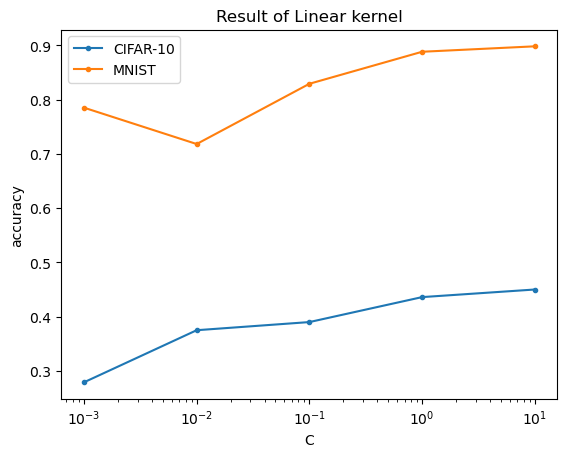

[0.279, 0.375, 0.39, 0.436, 0.45] [0.785, 0.718, 0.829, 0.888, 0.898]


In [15]:
import matplotlib.pyplot as plt
plt.title('Result of Linear kernel')
plt.xlabel('C')
plt.ylabel('accuracy')

plt.plot(gamma, acc_l, marker='o', markersize=3)
plt.plot(gamma, acc_m, marker='o', markersize=3)
plt.xscale('log')
plt.legend(['CIFAR-10', 'MNIST'])
plt.show()
print(acc_l,acc_m)